# EPI 270   

# Beginner DBDP Tutorial: Working with Continuous Glucose Monitoring (CGM) Data
# Credit: Brinnae Bent, PhD


In this case study, we will be using continuous glucose monitoring (CGM) data. We will be performing the first few steps of the Digital Biomarker Discvoery Pipeline: 

1. Pre-process the data
2. Exploratory data analysis
3. Feature Engineering (using the DBDP cgmquantify module)

### Level
Beginner. You have limited knowledge of Python/R. This tutorial is a step-by-step guide.

### System Requirements
* Python (3.0.0+) - If you don't yet have Python installed, please follow [this video tutorial](https://www.youtube.com/watch?v=YJC6ldI3hWk) on how to download Python through Anaconda

For beginners, I recommend using either JupyterLab or Visual Studio Code to interface with your notebooks.

### Objectives
* Learn how to work with CGM data
* Learn the first 3 steps of the digital biomarker discovery pipeline
* Compute glucose variability metrics on data

### Dataset
We will be using a small example dataset from a single person's week long CGM data. This data has been de-identified and time shifted.


_____

### Import libraries 
If you installed with Anaconda, some of these libaries should be built-in. 

You can check if you have them by running the next block of code.

If you get an error, install them in your terminal window using "pip install X" where X is the package missing

In [1]:
import numpy as np
import pandas as pd 
import datetime as datetime
import matplotlib.pyplot as plt

### Pre-processing: Import and Clean CGM Data
In python, functions are used by library.function. Below, we are using the pandas library (which we nicknamed "pd" when we imported it above). We want to use the read_csv function within the pandas library.

If you added the data-set in your local folder (the one your code is in), you can proceed. You may need to change the filename to be your entire folder path and filename if you have the dataset elsewhere.

We are importing the data as a special type of data structure, the dataframe. Learn more about data structures and, in particular, dataframes [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html).

In [2]:
data = pd.read_csv('test_file.csv') 

Let's take a peak at the data...

In [3]:
data

,Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Patient Info,Device Info,Source Device ID,Glucose Value (mg/dL),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mg/dL/min)
0,1,NaN,FirstName,NaN,Joe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,LastName,NaN,Schmoe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,DateOfBirth,NaN,1/1/1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,Device,NaN,NaN,Dexcom G6 Mobile App,iPhone G6,NaN,NaN,NaN,NaN,NaN
4,5,NaN,Alert,Fall,NaN,NaN,iPhone G6,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2154,2155,2016-11-01T08:59:03,EGV,NaN,NaN,NaN,iPhone G6,145.0,NaN,NaN,NaN,NaN
2155,2156,2016-11-01T09:04:02,EGV,NaN,NaN,NaN,iPhone G6,139.0,NaN,NaN,NaN,NaN
2156,2157,2016-11-01T09:09:03,EGV,NaN,NaN,NaN,iPhone G6,136.0,NaN,NaN,NaN,NaN
2157,2158,2016-11-01T09:14:02,EGV,NaN,NaN,NaN,iPhone G6,126.0,NaN,NaN,NaN,NaN


In [4]:
data[0:15]

,Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Patient Info,Device Info,Source Device ID,Glucose Value (mg/dL),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mg/dL/min)
0,1,NaN,FirstName,NaN,Joe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,LastName,NaN,Schmoe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,DateOfBirth,NaN,1/1/1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,Device,NaN,NaN,Dexcom G6 Mobile App,iPhone G6,NaN,NaN,NaN,NaN,NaN
4,5,NaN,Alert,Fall,NaN,NaN,iPhone G6,NaN,NaN,NaN,NaN,3.0
5,6,NaN,Alert,High,NaN,NaN,iPhone G6,200.0,NaN,NaN,NaN,NaN
6,7,NaN,Alert,Low,NaN,NaN,iPhone G6,80.0,NaN,NaN,NaN,NaN
7,8,NaN,Alert,Signal Loss,NaN,NaN,iPhone G6,NaN,NaN,NaN,0:20:00,NaN
8,9,NaN,Alert,Rise,NaN,NaN,iPhone G6,NaN,NaN,NaN,NaN,3.0
9,10,NaN,Alert,Urgent Low,NaN,NaN,iPhone G6,55.0,NaN,NaN,NaN,NaN


Okay, the data is pretty messy. For today's purposes, we only care about the Timestamp and Glucose columns. We want to drop everything else from the dataset.

In [5]:
# Instantiate a new dataframe. We will call this one "df"
df = pd.DataFrame() # This creates an empty data frame

# Pull timestamp and glucose columns into the new, empty dataframe. We will change their names to "DateTime" and "Glucose" 
df['DateTime'] = data['Timestamp (YYYY-MM-DDThh:mm:ss)']
# For glucose, we also want to change the data to a number. Right now, Python thinks the glucose column values are strings (you can think of a string as text). We will wrap the function in pd.to_numeric() to convert the column to numbers.
df['Glucose'] = pd.to_numeric(data['Glucose Value (mg/dL)'])

# The first 12 rows don't even have matching glucose + time values, so let's drop those
df.drop(df.index[:12], inplace=True)

Great! We now have a clean dataframe to work with. Check it out below!

In [6]:
df

,DateTime,Glucose
12,2016-10-24T11:29:17,102.0
13,2016-10-24T11:34:17,100.0
14,2016-10-24T11:39:17,98.0
15,2016-10-24T11:44:17,94.0
16,2016-10-24T11:49:18,95.0
...,...,...
2154,2016-11-01T08:59:03,145.0
2155,2016-11-01T09:04:02,139.0
2156,2016-11-01T09:09:03,136.0
2157,2016-11-01T09:14:02,126.0


Now, let's deal with the DateTime. Remember how we had to change the glucose column to be numbers instead of strings? 

Well, we have to tell Python that the "DateTime" column is a datetime data type. 

In [7]:
# We will use pd.to_datetime() to convert the Time column to a datetime object. We need to tell Python what the current format is. 
df['DateTime'] =  pd.to_datetime(df['DateTime'], format='%Y-%m-%dT%H:%M:%S')

# I would also like to make a new column, "Day", with just the Day of the DateTime column.
df['Day'] = df['DateTime'].dt.date

In [8]:
df

,DateTime,Glucose,Day
12,2016-10-24 11:29:17,102.0,2016-10-24
13,2016-10-24 11:34:17,100.0,2016-10-24
14,2016-10-24 11:39:17,98.0,2016-10-24
15,2016-10-24 11:44:17,94.0,2016-10-24
16,2016-10-24 11:49:18,95.0,2016-10-24
...,...,...,...
2154,2016-11-01 08:59:03,145.0,2016-11-01
2155,2016-11-01 09:04:02,139.0,2016-11-01
2156,2016-11-01 09:09:03,136.0,2016-11-01
2157,2016-11-01 09:14:02,126.0,2016-11-01


Did you notice that your index (the bold numbers on the left side of the dataframe) starts at 12? That is because we removed the first 12 rows from the dataframe. Let's re-index the dataframe so the index will start at 0.

In [9]:
df = df.reset_index(drop=True)

In [10]:
df

,DateTime,Glucose,Day
0,2016-10-24 11:29:17,102.0,2016-10-24
1,2016-10-24 11:34:17,100.0,2016-10-24
2,2016-10-24 11:39:17,98.0,2016-10-24
3,2016-10-24 11:44:17,94.0,2016-10-24
4,2016-10-24 11:49:18,95.0,2016-10-24
...,...,...,...
2142,2016-11-01 08:59:03,145.0,2016-11-01
2143,2016-11-01 09:04:02,139.0,2016-11-01
2144,2016-11-01 09:09:03,136.0,2016-11-01
2145,2016-11-01 09:14:02,126.0,2016-11-01


_____
### Exploratory Data Analysis
We will explore just a few components of Exploratory Data Analysis with CGM data. 

If we want to get a brief overview of our data, running the describe() function on our dataframe will give us a nice summary, including count, mean, standard deviation, median, minimum, and maximum.

In [11]:
df.describe()

,Glucose
count,2147.000000
mean,111.900792
std,28.805773
min,49.000000
25%,97.000000
50%,105.000000
75%,119.000000
max,261.000000


Let's start with a simple plot, so I can start to understand what is happening to my data over time. This will also enable me to see missing data. 

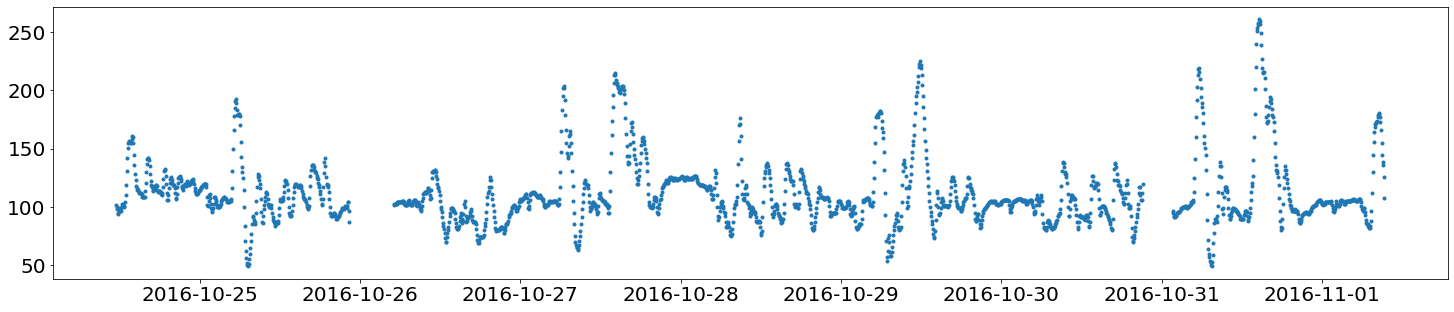

In [12]:
# Designate a figure size and font size
plt.figure(figsize=(25,5))
plt.rcParams.update({'font.size': 20})

# Plot
plt.plot(df['DateTime'], df['Glucose'], '.', color = '#1f77b4')

It looks like we have a little bit of missing data, on 10-26 and on 10-31. We'll cover that later. 


Glucose excursions (very high and very low glucose values) are important for assessing glycemic health. Let's re-plot this, but including the mean and standard deviation of glucose on the plot.

Text(0, 0.5, 'Glucose')

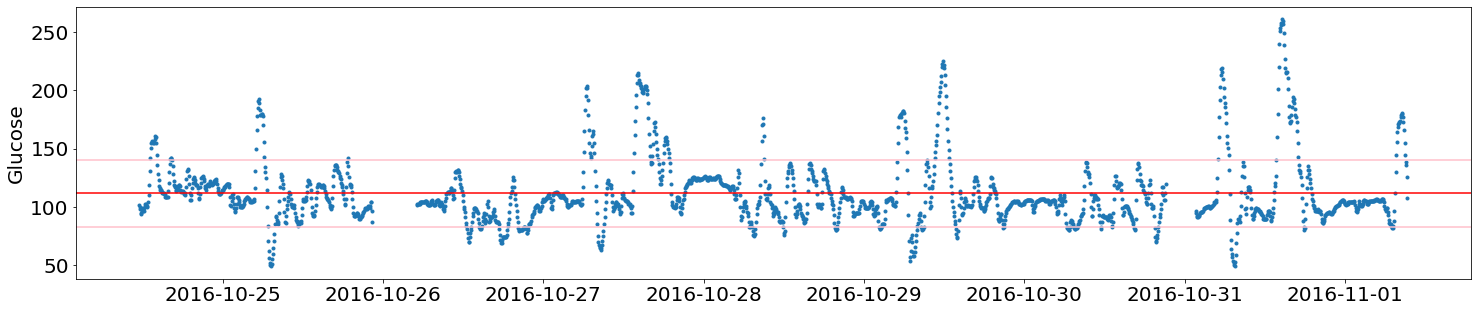

In [13]:
# Calculate the mean and standard deviation of glucose. We will draw 3 lines on the plot: The mean, 1 standard deviation above the mean, and 1 standard deviation below the mean.
glucose_mean = np.mean(df['Glucose'])
up = np.mean(df['Glucose']) + np.std(df['Glucose'])
dw = np.mean(df['Glucose']) - np.std(df['Glucose'])

# Same plot as above
plt.figure(figsize=(25,5))
plt.rcParams.update({'font.size': 20})
plt.plot(df['DateTime'], df['Glucose'], '.', color = '#1f77b4')

# Plot 3 horizontal lines
plt.axhline(y=glucose_mean, color='red', linestyle='-')
plt.axhline(y=up, color='pink', linestyle='-')
plt.axhline(y=dw, color='pink', linestyle='-')

# Add a label
plt.ylabel('Glucose')

Now, what if we wanted to see a smoothed graph that performed interpolation between points. We can use lowess smoothing to do this.

In [14]:
# Import lowess from the statsmodels library
from statsmodels.nonparametric.smoothers_lowess import lowess

First, we will create a new data frame that is the smoothed version of our data:

In [15]:
filteres = lowess(df['Glucose'], df['DateTime'], is_sorted=True, frac=0.015, it=0) #0.025
filtered = pd.to_datetime(filteres[:,0], format='%Y-%m-%dT%H:%M:%S') 

Next, we will plot the smoothed data:

Text(0, 0.5, 'Glucose')

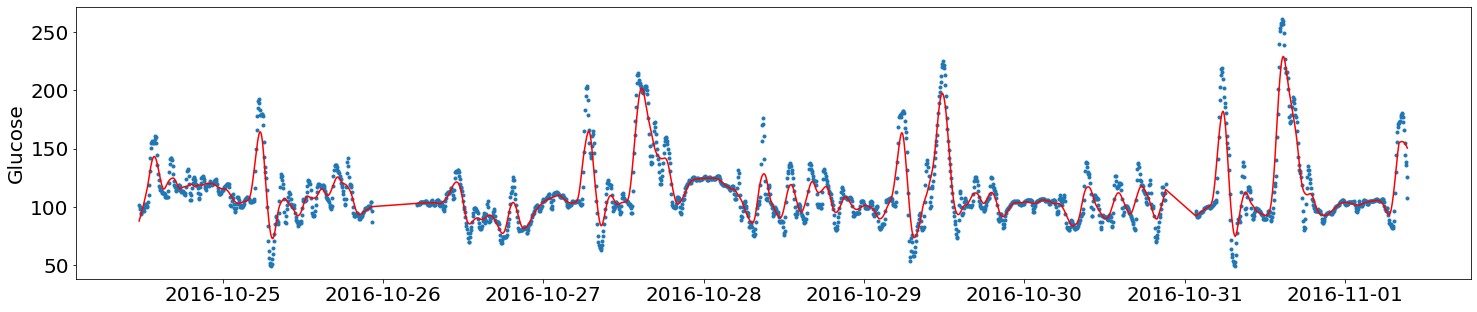

In [16]:
# Set sizes
plt.figure(figsize=(25,5))
plt.rcParams.update({'font.size': 20})

# Same plot as before
plt.plot(df['DateTime'], df['Glucose'], '.')

# Plot smoothed data
plt.plot(filtered, filteres[:,1], 'r')

#Labels
plt.ylabel('Glucose')

For more or less smoothing, you can change the "frac" argument in the lowess function above. It is currently set at 0.015. Why not try 0.03 and see what happens?

____________
In order to determine the distribution of Glucose in the dataset, let's plot a histogram using the matplotlib hist function.

For a list of all of the arguments to the matplotlib hist() function, check out the documentation [here](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html).

Text(0, 0.5, 'Count')

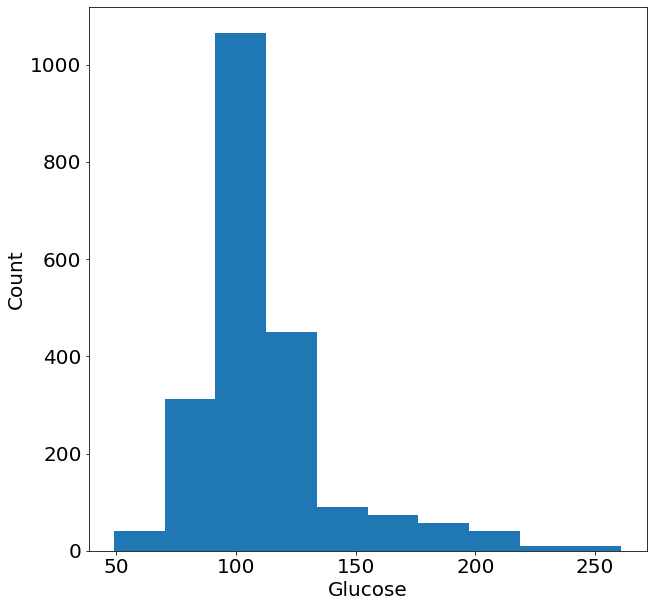

In [17]:
# Set sizes
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 20})

# Plot histogram
plt.hist(df['Glucose'])

# Labels
plt.xlabel('Glucose')
plt.ylabel('Count')

__________
This is a *very* brief overview of Exploratory Data Analysis. I encourage you to continue exploring your data using the [tools available](https://github.com/DigitalBiomarkerDiscoveryPipeline/Exploratory-Data-Analysis/) in the DBDP!

_____
### Feature Engineering

Feature engineering is the process by which we engineer features that we can then use as inputs in models to predict an outcome. 

The process of Feature Engineering can be data-driven or domain-driven. We will do a couple of each here:

#### Data-driven Feature Engineering

My go-to data-driven features include summary metrics. Let's compute those below:

In [18]:
meanG = np.nanmean(df['Glucose'])
medianG = np.nanmedian(df['Glucose'])
minG = np.nanmin(df['Glucose'])
maxG = np.nanmax(df['Glucose'])
Q1G = np.nanpercentile(df['Glucose'], 25)
Q3G = np.nanpercentile(df['Glucose'], 75)

We can also compute metrics over each day:

In [19]:
# Standard Deviation over all days
interdaysd = np.std(df['Glucose'])

# Standard Deviation for each day
intradaysd =[]

for i in pd.unique(df['Day']):
    intradaysd.append(np.std(df[df['Day']==i]["Glucose"]))
    
# We can find the average intraday standard deviation:
intradaysd_mean = np.mean(intradaysd)



If we examine both the interdaysd and the intradaysd_mean, we see that they are different!

In [20]:
print(intradaysd_mean)
print(interdaysd)

24.389128553416437
28.799063508925432


#### Domain-driven Feature Engineering

Domain-driven feature engineering usually takes the most time but is often the most effective, especially when handling physiology-based metrics. Domain-driven feature engineering involves a literature review and a better understanding of the underlying physiology. 

Two metrics that are well known in diabetes literature to be indicative of glycemic health are the [glucose management index (GMI)](https://care.diabetesjournals.org/content/early/2018/09/17/dc18-1581) and the [J-index](https://diabetes.diabetesjournals.org/content/62/5/1398). Let's compute these features.

In [21]:
J = 0.001*((np.mean(df['Glucose'])+np.std(df['Glucose']))**2)

In [22]:
GMI = 3.31 + (0.02392*np.mean(df['Glucose']))

____
The DBDP CGMQuantify Module has 25+ pre-configured features that it computes. [cgmquanitfy module](https://github.com/DigitalBiomarkerDiscoveryPipeline/cgmquantify). The code is available [here](https://github.com/DigitalBiomarkerDiscoveryPipeline/cgmquantify/blob/master/cgmquantify/__init__.py).

You can also install the cgmquantify package and have access to its functions. (Remember to pip install the package. For full instructions on how to install it, see [here](https://github.com/DigitalBiomarkerDiscoveryPipeline/cgmquantify/blob/master/README.md))

In [23]:
import cgmquantify as cgm

In [24]:
data = cgm.importdexcom('test_file.csv')

print('interdaysd is: ' + str(cgm.interdaysd(data)))
print('interdaycv is: ' + str(cgm.interdaycv(data)))


interdaysd is: 28.799063508925432
interdaycv is: 25.73624640632626
TOR is: 1985
TIR is: 8750
POR is: 18.49091755938519
MAGE is: 135.42317380352645


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MODD is: 27.667695370831257
J_index is: 19.796449284660316
LBGI is: 0.9095514600407604
HBGI is: 0.9429935347767346
ADRR is: 21.343472829647837
CONGA24 is: 17.433750765189647
GMI is: 5.986666939916162
eA1c is: 5.526159993118995
summary is: (111.90079180251514, 105.0, 49.0, 261.0, 97.0, 119.0)


LAB QUESTION:

Do a literature search for eA1C and describe what it is, and why it may be a meaningful feature for these types of data. 

Calculate the eA1C for the sample. 



LAB QUESTION:

Perform a literature search for the time in range (TIR) and time out of range (TOR) for diabetes and describe why this is a meaningful feature in diabetes management. 

Calculate the ratio of time in range (TIR) vs time out of range (TOR) 


LAB QUESTION:

Perform a literature search related to continuous glucose monitoring and identify another feature that may be interesting to researchers or clinicians. Describe that features, and how it's calculated, and then implement the calulation below. 

Can't wait? [Here](https://machinelearningmastery.com/handle-missing-data-python/) is a great tutorial that shows you how to handle missing data. You will also find visualizations for assessing missing data in the DBDP [here](https://github.com/DigitalBiomarkerDiscoveryPipeline/Exploratory-Data-Analysis).

### Recommended DBDP Resources
This is a handy guide, but don't worry- everything you need is right here. If you want to know how to find those resources in the DBDP, they are available in the table below:

| Resource | How to use it | Language |
| ------ | ------ | ------ | 
| [Getting Started](https://github.com/DigitalBiomarkerDiscoveryPipeline/DBDP/wiki/USER-GUIDE) | User Guide for the DBDP | NA |
| [Pre-processing CGM data](https://github.com/DigitalBiomarkerDiscoveryPipeline/cgmquantify) | Import CGM data | Python | 
| [Exploratory Data Analysis](https://github.com/DigitalBiomarkerDiscoveryPipeline/Exploratory-Data-Analysis) | Explore data, examine missingness, unsupervised learning | Python, R | 
| [Feature Engineering CGM data](https://github.com/DigitalBiomarkerDiscoveryPipeline/cgmquantify) | Engineer features of glucose variability from CGM data | Python |

### Other Recommended Resources
* [Paper on glucose variability](https://journals.sagepub.com/doi/full/10.1177/1932296819826111)
 